In [1]:
from os.path import join
import matplotlib.pyplot as plt
import torch as pt
plt.rcParams["figure.dpi"] = 160


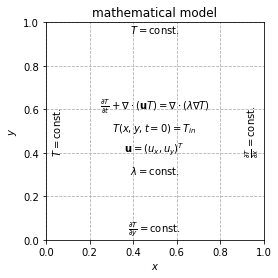

In [2]:
fig,ax = plt.subplots()
ax.set_title("mathematical model")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.text(0.5,0.95,r"$T = \mathrm{const.}$",ha = "center")
ax.text(0.5,0.05,r"$\frac{\partial T}{\partial y} = \mathrm{const.}$", ha = "center", va = "center")
ax.text(0.05,0.5,r"$T = \mathrm{const.}$",ha = "center",va = "center",rotation = 90)
ax.text(0.95,0.5,r"$\frac{\partial T}{\partial x} = \mathrm{const.}$",ha = "center",va = "center",rotation = 90)
dt_T = r"\frac{\partial T}{\partial t}"
div_T =r"\nabla\cdot\left(\mathbf{u}T\right)"
laplace_T = r"\nabla\cdot\left(\lambda \nabla T\right)"
ax.text(0.5,0.6,r"${:s} + {:s} = {:s}$".format(dt_T,div_T,laplace_T),ha ="center")
ax.text(0.5,0.5,r"$T(x,y,t=0) = T_{in}$",ha = "center")
ax.text(0.5,0.4,r"$\mathbf{u} = (u_x,u_y)^{T}$",ha ="center")
ax.text(0.5,0.3,r"$\lambda = \mathrm{const.}$",ha = "center")
ax.set_aspect("equal")
ax.grid(ls="--")
plt.show()


In [3]:
class Mesh(object):
    def __init__(self,L_x,L_y,N_x,N_y,grad_x,grad_y):
        self.L_x = L_x
        self.L_y = L_y
        self.N_x = N_x
        self.N_y = N_y
        self.dx = self._compute_cell_width(L_x,N_x,grad_x)
        self.dy = self._compute_cell_width(L_y,N_y,grad_y)
        self.x = pt.cumsum(self.dx,0) - self.dx*0.5
        self.y = pt.cumsum(self.dy,0) - self.dy*0.5
        xf = self.x - self.dx*0.5
        self.xf = pt.cat( (xf,pt.tensor([xf[-1]+self.dx[-1]]) ) )
        yf = self.y - self.dy*0.5
        self.yf = pt.cat((yf, pt.tensor([yf[-1]+self.dy[-1]] )))
    def _compute_cell_width(self,L,N,grad):
        if grad == 1.0:
            delta = L/N
            return pt.ones(N)*delta
        else:
            cell_width = pt.linspace(1.0,grad,N)
            width_0 = L/cell_width.sum()
            return cell_width*width_0
    def cell_id(self,i,j) -> int:
        return self.N_x*j + i
    def visualise(self,show_ids = True):
        fig, ax = plt.subplots()
        xx,yy = pt.meshgrid(self.x,self.y,indexing = "ij")
        ax.scatter(xx,yy,s = 5,c = "k",zorder = 6)
        for xf_i,yf_i in zip(self.x,self.y):
            ax.axvline(xf_i,0.0,self.L_x, ls = "--",c = "k",alpha = 0.3)
            ax.axhline(yf_i,0.0,self.L_y, ls ="--",c = "k",alpha = 0.3)
        fontsize = int(10*5/(self.N_x))
        if show_ids:
            for i in range(self.N_x):
                for j in range(self.N_y):
                    ax.text(self.x[i],self.y[j]+0.2*self.dy[j],f"({i},{j})", ha = "center",va = "center",fontsize = fontsize)
                    ax.text(self.x[i],self.y[j] - 0.2*self.dy[j],f"{self.cell_id(i,j)}",ha = "center",va = "center",fontsize = fontsize)
        ax.set_xlim(-0.01,self.L_x+0.01)
        ax.set_ylim(-0.01,self.L_y+0.01)
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        ax.set_aspect("equal")
        ax.set(frame_on = False)
        return fig, ax
        

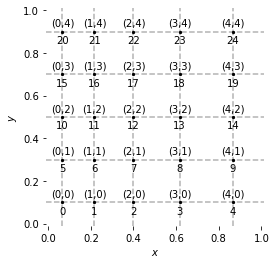

In [4]:
mesh = Mesh(1.0,1.0,5,5,1.0,1.0)
assert pt.allclose(mesh.xf,pt.linspace(0.0,1.0,6))
assert pt.allclose(mesh.x,pt.linspace(0.1,0.9,5))
mesh = Mesh(1.0,1.0,5,5,2.0,1.0)
assert pt.isclose(2.0*mesh.dx[0],mesh.dx[-1])
fig,ax = mesh.visualise()
plt.show()


In [5]:
class VolScalarFeild(object):
    def __init__(self,mesh,name,value,bc):
        self.mesh = mesh
        self.name = name
        self.internal_field = pt.ones((mesh.N_x,mesh.N_y))
        self.internal_field *= value
        self.bc = bc
    
    def visualize(self):
        fig,ax = self.mesh.visualize(False)
        ax.set_title(f"internal feild {self.name}")
        pc = ax.pcolormesh(self.mesh.xf,self.mesh.yf,self.internal_field,label = f"{self.name}")
        plt.colorbar(pc,ax=ax)
        return fig,ax
    def __equal__(self,other):
        return self is other
        

In [6]:
T1 = VolScalarFeild(mesh,"T",0.0,None)
T2 = VolScalarFeild(mesh,"T",0.0,None)
assert T1 == T1
assert not T1 == T2

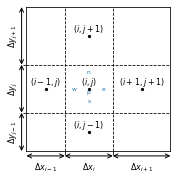

<Figure size 288x288 with 0 Axes>

In [7]:
fig= plt.figure(figsize = (2.5,2.5),frameon = False)
ax = fig.add_axes((0.2,0.2,0.8,0.8))
ax.set_xticks((0.8,1.8))
ax.set_yticks((0.8,1.8))
ax.set_xlim(0.0,3.0)
ax.set_ylim(0.0,3.0)
ax.set_xticklabels(())
ax.set_yticklabels(())
ax.grid(ls="--",color="k")
xi = (0.4,1.3,1.3,1.3,2.4)
yi = (1.3,0.4,1.3,2.4,1.3)
xyi = ("(i-1,j)","(i,j-1)","(i,j)","(i,j+1)","(i+1,j+1)")
ax.scatter(xi,yi,c="k",marker="o",s=5)
for xi_i,yi_i,xyi_i in zip(xi,yi,xyi):
    ax.text(xi_i,yi_i,f"${xyi_i}$",fontsize = 8,ha ="center",va="bottom")
ax.annotate("",(0.0,-0.1),(0.8,-0.1),arrowprops=dict(arrowstyle="<->",shrinkA=0.0,shrinkB=0.0),annotation_clip=False)
ax.annotate("",(0.8,-0.1),(1.8,-0.1),arrowprops=dict(arrowstyle="<->",shrinkA = 0.0,shrinkB = 0.0),annotation_clip = False)
ax.annotate("",(1.8,-0.1),(3.0,-0.1),arrowprops=dict(arrowstyle="<->",shrinkA=0,shrinkB=0),annotation_clip=False)
ax.text(0.4,-0.4,r"$\Delta x_{i-1}$",ha="center",fontsize=8)
ax.text(1.3,-0.4,r"$\Delta x_{i}$",ha="center",fontsize = 8)
ax.text(2.4,-0.4,r"$\Delta x_{i+1}$",ha="center",fontsize = 8)
ax.annotate("",(-0.1,0.0),(-0.1,0.8),arrowprops=dict(arrowstyle= "<->",shrinkA=0,shrinkB=0),annotation_clip=False)
ax.annotate("",(-0.1,0.8),(-0.1,1.8),arrowprops=dict(arrowstyle="<->",shrinkA = 0,shrinkB = 0),annotation_clip=False)
ax.annotate("",(-0.1,1.8),(-0.1,3.0),arrowprops=dict(arrowstyle="<->",shrinkA=0.0,shrinkB=0.0),annotation_clip=False)
ax.text(-0.4,0.4,r"$\Delta y_{j-1}$",va="center",fontsize=8,rotation = 90)
ax.text(-0.4,1.3,r"$\Delta y_{j}$",va="center",fontsize = 8,rotation = 90)
ax.text(-0.4,2.4,r"$\Delta y_{j+1}$",va="center",fontsize=8,rotation=90)
ax.text(1.3,1.6,r"n",ha="center",fontsize = 6,color="C0")
ax.text(1.3,1.19,r"p",ha="center",fontsize = 6,color="C0")
ax.text(1.0,1.25,r"w",ha="center",fontsize = 6,color="C0")
ax.text(1.6,1.25,r"e",ha="center",fontsize = 6,color="C0")
ax.text(1.3,1.0,r"s",ha="center",fontsize = 6,color="C0")

plt.figure(figsize = (4,4))
plt.show()